In [128]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test on dormant Markov

In [129]:
model, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server="/data/tianyu_guo/birth/gens/special/dormant_copy", n_layers=1, n_heads=1, bos_num=1, train_steps=4999, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)

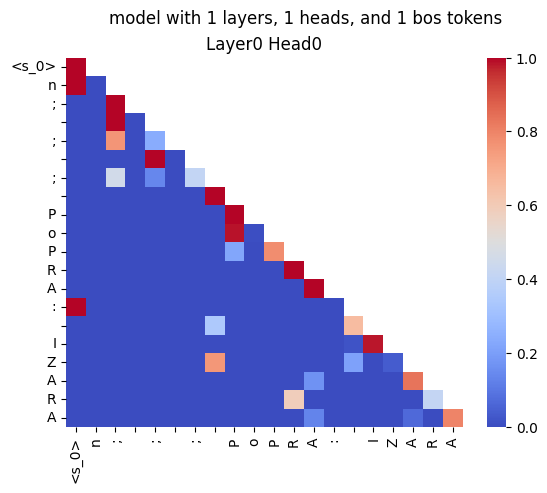

In [130]:
seq_idx, layer_idx, head_idx, seq_len = 200, 0, 0, 20
text = ds.decode(x[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
ax = plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

In [46]:
(-ds.marginal).argsort()[:30], ds.decode((-ds.marginal).argsort()[:30])

(array([ 1, 43, 58, 53, 39, 46, 57, 56, 52, 47,  0, 50, 42, 59, 51, 63,  6,
        61, 44, 41, 45, 21, 40, 54, 10,  8, 13, 60, 49, 32]),
 [' ',
  'e',
  't',
  'o',
  'a',
  'h',
  's',
  'r',
  'n',
  'i',
  '\n',
  'l',
  'd',
  'u',
  'm',
  'y',
  ',',
  'w',
  'f',
  'c',
  'g',
  'I',
  'b',
  'p',
  ':',
  '.',
  'A',
  'v',
  'k',
  'T'])

In [264]:
(-ds.marginal).argsort()[25:30]

array([ 8, 13, 60, 49, 32])

In [265]:
special_idxs = [0, 6, 47, 21]

In [286]:
# zero_out_idxs = ds.idxs + [9, 0, 47, 1, 2, 3, 4, 5, 6, 8]
# subset = list((-ds.marginal).argsort()[5:30])
# for idx in special_idxs:
#     subset.remove(idx)
x_dormant = np.array([[56, 52, 50, i, 0, i] for i in ds.tok_range])
# x_dormant = ds.no_trigger_gen_seq(rng=np.random.default_rng([42, 27]), subset=subset)
# x_dormant = np.array([x_dormant[:-1]])
x_dormant = torch.from_numpy(x_dormant)
predicts_dormant, outputs_list_dormant = model.modified_forward_with_hook(x_dormant, hook)

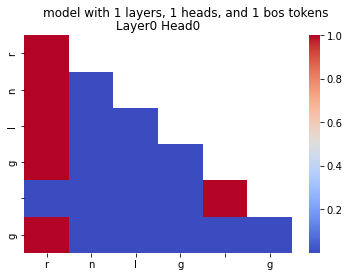

In [293]:
seq_idx, layer_idx, head_idx, seq_len = 45, 0, 0, 6
text = ds.decode(x_dormant[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
ax = plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list_dormant, text)
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

In [274]:
special_idxs = [i for i in ds.tok_range if outputs_list_dormant[0]['attn_weights'][i, 0, 3, 0] < 0.9]
all_attn_weights = [outputs_list_dormant[0]['attn_weights'][i, 0, 3, 0].detach().numpy() for i in ds.tok_range]

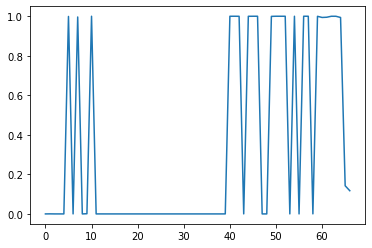

In [275]:
# tmp = all_attn_weights.pop(ds.idxs)
plt.plot(all_attn_weights)

In [305]:
i = 30
outputs_list_dormant[0]['value_states'][i, 0, 3, :]

tensor([ 1.5099e-01,  7.0868e-01, -2.0070e+00, -1.9275e+00,  7.0970e-01,
        -1.5604e-01,  1.6016e+00,  3.2554e-01, -1.9159e+00,  8.4411e-01,
        -1.0408e+00, -3.7834e-01, -1.4630e+00, -1.6671e+00,  5.2310e-01,
         7.7141e-01, -2.8056e-01,  6.8931e-01,  1.6095e+00,  4.7285e-01,
         4.8262e-01,  9.2262e-01, -8.0866e-01,  4.0201e-03,  1.4670e-01,
        -1.2257e-01,  8.4486e-01, -7.7706e-01,  4.7475e-01,  2.5140e-01,
        -6.1554e-01,  7.8979e-01,  1.0282e+00,  4.9250e-02,  1.0392e+00,
         2.5374e+00, -1.1297e+00, -8.2233e-03, -2.1591e-01,  1.9042e+00,
         3.0676e-01, -1.0048e-01,  3.7116e-01, -5.3754e-01, -5.7643e-01,
         8.4629e-01, -9.0285e-02,  6.6789e-01, -2.8922e-01, -9.4762e-01,
         1.8801e+00, -8.5038e-01, -6.2334e-01, -1.3108e-01, -4.8467e-02,
        -9.3250e-01,  9.2511e-01, -1.2199e-01, -9.0444e-01, -1.0560e+00,
        -6.7932e-02,  9.3083e-01,  9.1253e-01, -2.2083e+00,  3.5943e-01,
         1.1311e-01, -1.3219e+00, -5.1564e-01, -6.3

In [300]:
outputs_list_dormant[0]['attn_input'][i, 3, :]

tensor([ 1.6102, -1.4456,  0.3037, -0.7280, -0.3218,  0.2402, -0.7457, -0.0289,
         1.7039,  0.4016,  1.1626, -1.7152, -0.6390, -0.5437, -0.2106, -0.5226,
        -2.6130, -2.1146,  1.5046,  1.0595,  0.6432,  0.1012,  1.7966,  0.7594,
         0.7215, -0.5928,  0.4655,  0.0574, -1.1593,  0.8344, -0.5405, -2.1378,
         1.4961,  0.3791,  0.0940,  0.4115,  0.6226,  0.3165,  1.5201, -2.2190,
        -1.3447,  1.4577,  0.6777,  1.3845, -0.7469,  0.1276, -1.0775,  0.7110,
        -2.0212, -1.0259,  0.7736, -1.4688,  1.0585, -0.5103, -0.9482, -0.0884,
         0.1705,  0.0982, -0.8612, -0.9238,  1.1775, -0.1281,  0.2641, -0.2785,
        -0.7264, -0.4021, -1.2717,  1.0175,  0.9388, -0.4908,  1.2892,  0.8820,
         0.1861, -1.1184, -0.6288,  1.1385,  0.0434, -0.3283,  1.5173, -0.2286,
        -2.2127,  1.9510,  0.3924, -0.3024, -1.3221,  3.2626, -1.5052,  1.0309,
         1.0324,  1.3358,  1.3859, -0.4248,  1.5546, -0.6096,  0.8582,  0.5355,
         0.1104, -1.3317, -1.2019,  2.26

# Problem: dormant copy mechanism has shortcut which is that it can attend to itself when not on triggers

# Now test on pure markov task

In [18]:
model, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server="/data/tianyu_guo/birth/gens/special/markov", n_layers=1, n_heads=1, bos_num=1, train_steps=4999, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")

In [13]:
probs = F.softmax(predicts, dim=-1)
predict_probs = torch.gather(probs, 2, y.unsqueeze(2))
logloss = -torch.log(torch.gather(probs, 2, y.unsqueeze(2))).mean()
logloss

tensor(5.7606, grad_fn=<NegBackward0>)

In [22]:
# cond = torch.from_numpy(ds.cond).repeat(256)
cond = torch.from_numpy(ds.cond)
probs_oracle = np.zeros_like(probs.detach().numpy())
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        probs_oracle[i][j] = cond[x[i, j]]
probs_oracle = torch.from_numpy(probs_oracle)
predict_probs_oracle = torch.gather(probs_oracle, 2, y.unsqueeze(2))
logloss = -torch.log(predict_probs_oracle[:, 1:, :]).mean()
logloss

tensor(2.4527)

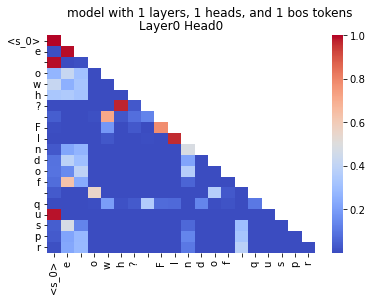

In [307]:
seq_idx, layer_idx, head_idx, seq_len = 134, 0, 0, 20
text = ds.decode(x[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
ax = plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

# Test on dormant copy 2

In [6]:
n_layers = 1
n_heads = 1
bos_num = 1
train_steps = 4999
path_local = f"/Users/guotianyu/GitHub/birth/gens/special/dormant_copy/model_L1_H1_bos1_delim0/params.yaml"
path_server = f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/params.yaml"
try:
    cfg = OmegaConf.load(path_local)
except:
    cfg = OmegaConf.load(path_server)
model = Transformer(cfg.model_args)
model.eval()


state_path_local = f"/Users/guotianyu/GitHub/birth/gens/special/dormant_copy/model_L1_H1_bos1_delim0/state_{train_steps}.pt"
state_path_server = f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/state_{train_steps}.pt"
try:
    state = torch.load(state_path_local, map_location="cpu")
except:
    state = torch.load(state_path_server, map_location="cpu")
model.load_state_dict(state["model_state_dict"], strict=False, )
import pickle
import numpy as np

try:
    with open("/Users/guotianyu/GitHub/birth/data/bos1_d0/meta.pickle", "rb") as f:
        meta_info = pickle.load(f)
except:
    with open("/data/tianyu_guo/birth/data/bos1_d0/meta.pickle", "rb") as f:
        meta_info = pickle.load(f)

# data_cfg = OmegaConf.structured(meta_info)


ds = make_dataset(cfg, meta_info)
x = ds.gen_batch(rng=np.random.default_rng([42, 27]), batch_size=cfg.optim_args.batch_size)
x = torch.from_numpy(x)
# y = torch.from_numpy(y)
x = x[:, :-1]
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)

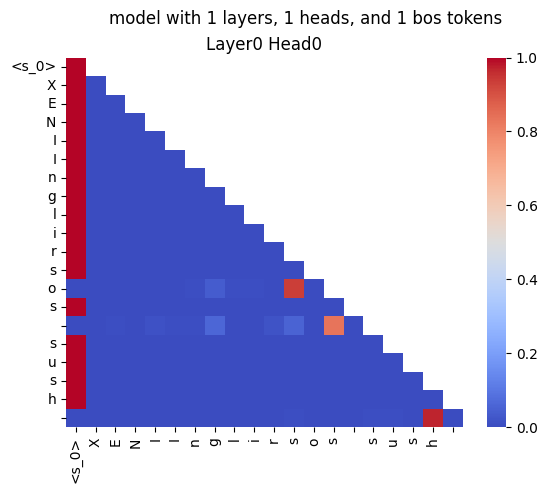

In [37]:
seq_idx, layer_idx, head_idx, seq_len = 20, 0, 0, 20
text = ds.decode(x[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
ax = plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

In [38]:
x_dormant = np.array([[65, 56, 52, 50, i, 0, i] for i in ds.tok_range])
x_dormant = torch.from_numpy(x_dormant)
predicts_dormant, outputs_list_dormant = model.modified_forward_with_hook(x_dormant, hook)
cutoff = 0.9
trigger_toks = [i for i in ds.tok_range if outputs_list_dormant[0]['attn_weights'][i, 0, 4, 0]<cutoff]

In [41]:
ds.decode(ds.idxs), ds.idxs

(['a', 'o', 't', 'e', ' '], [39, 53, 58, 43, 1])

In [42]:
trigger_toks, ds.decode(trigger_toks)

([1, 3, 9, 39, 43, 53, 58], [' ', '$', '3', 'a', 'e', 'o', 't'])

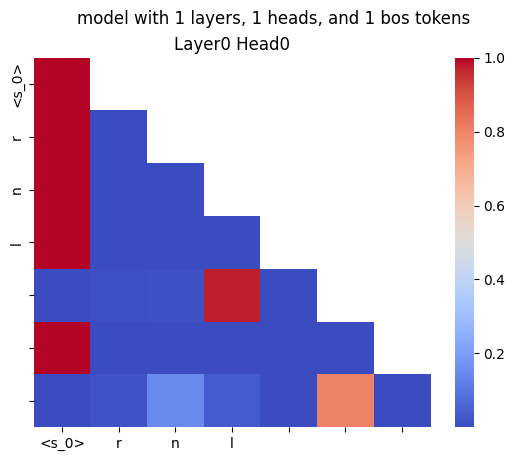

In [62]:
seq_idx, layer_idx, head_idx, seq_len = 1, 0, 0, 7
text = ds.decode(x_dormant[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
ax = plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list_dormant, text)
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

In [51]:
y_dormant = x_dormant[:, 1:]
probs_dormant = F.softmax(predicts_dormant, dim=-1)
predict_probs_dormant = torch.gather(probs_dormant, 2, y_dormant.unsqueeze(2))
logloss_dormant = -torch.log(torch.gather(probs_dormant, 2, y_dormant.unsqueeze(2))).mean()


In [65]:
seq_idx = 1
probs_dormant[seq_idx, 4].argmax()

tensor(50)

In [71]:
outputs_list_steps = {}
steps_list = []
# f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/state_{train_steps}.pt"
dir_name = f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0"
for fn in os.listdir(dir_name):
    if 'state' not in fn:
        continue
    step = int(fn.split('.')[0].split('_')[1])
    steps_list.append(step)
    state = torch.load(os.path.join(dir_name, fn), map_location="cpu")
    model.load_state_dict(state["model_state_dict"], strict=False, )
    predicts, outputs_list = model.modified_forward_with_hook(x, hook)
    outputs_list_steps[step] = outputs_list
steps_list.sort()

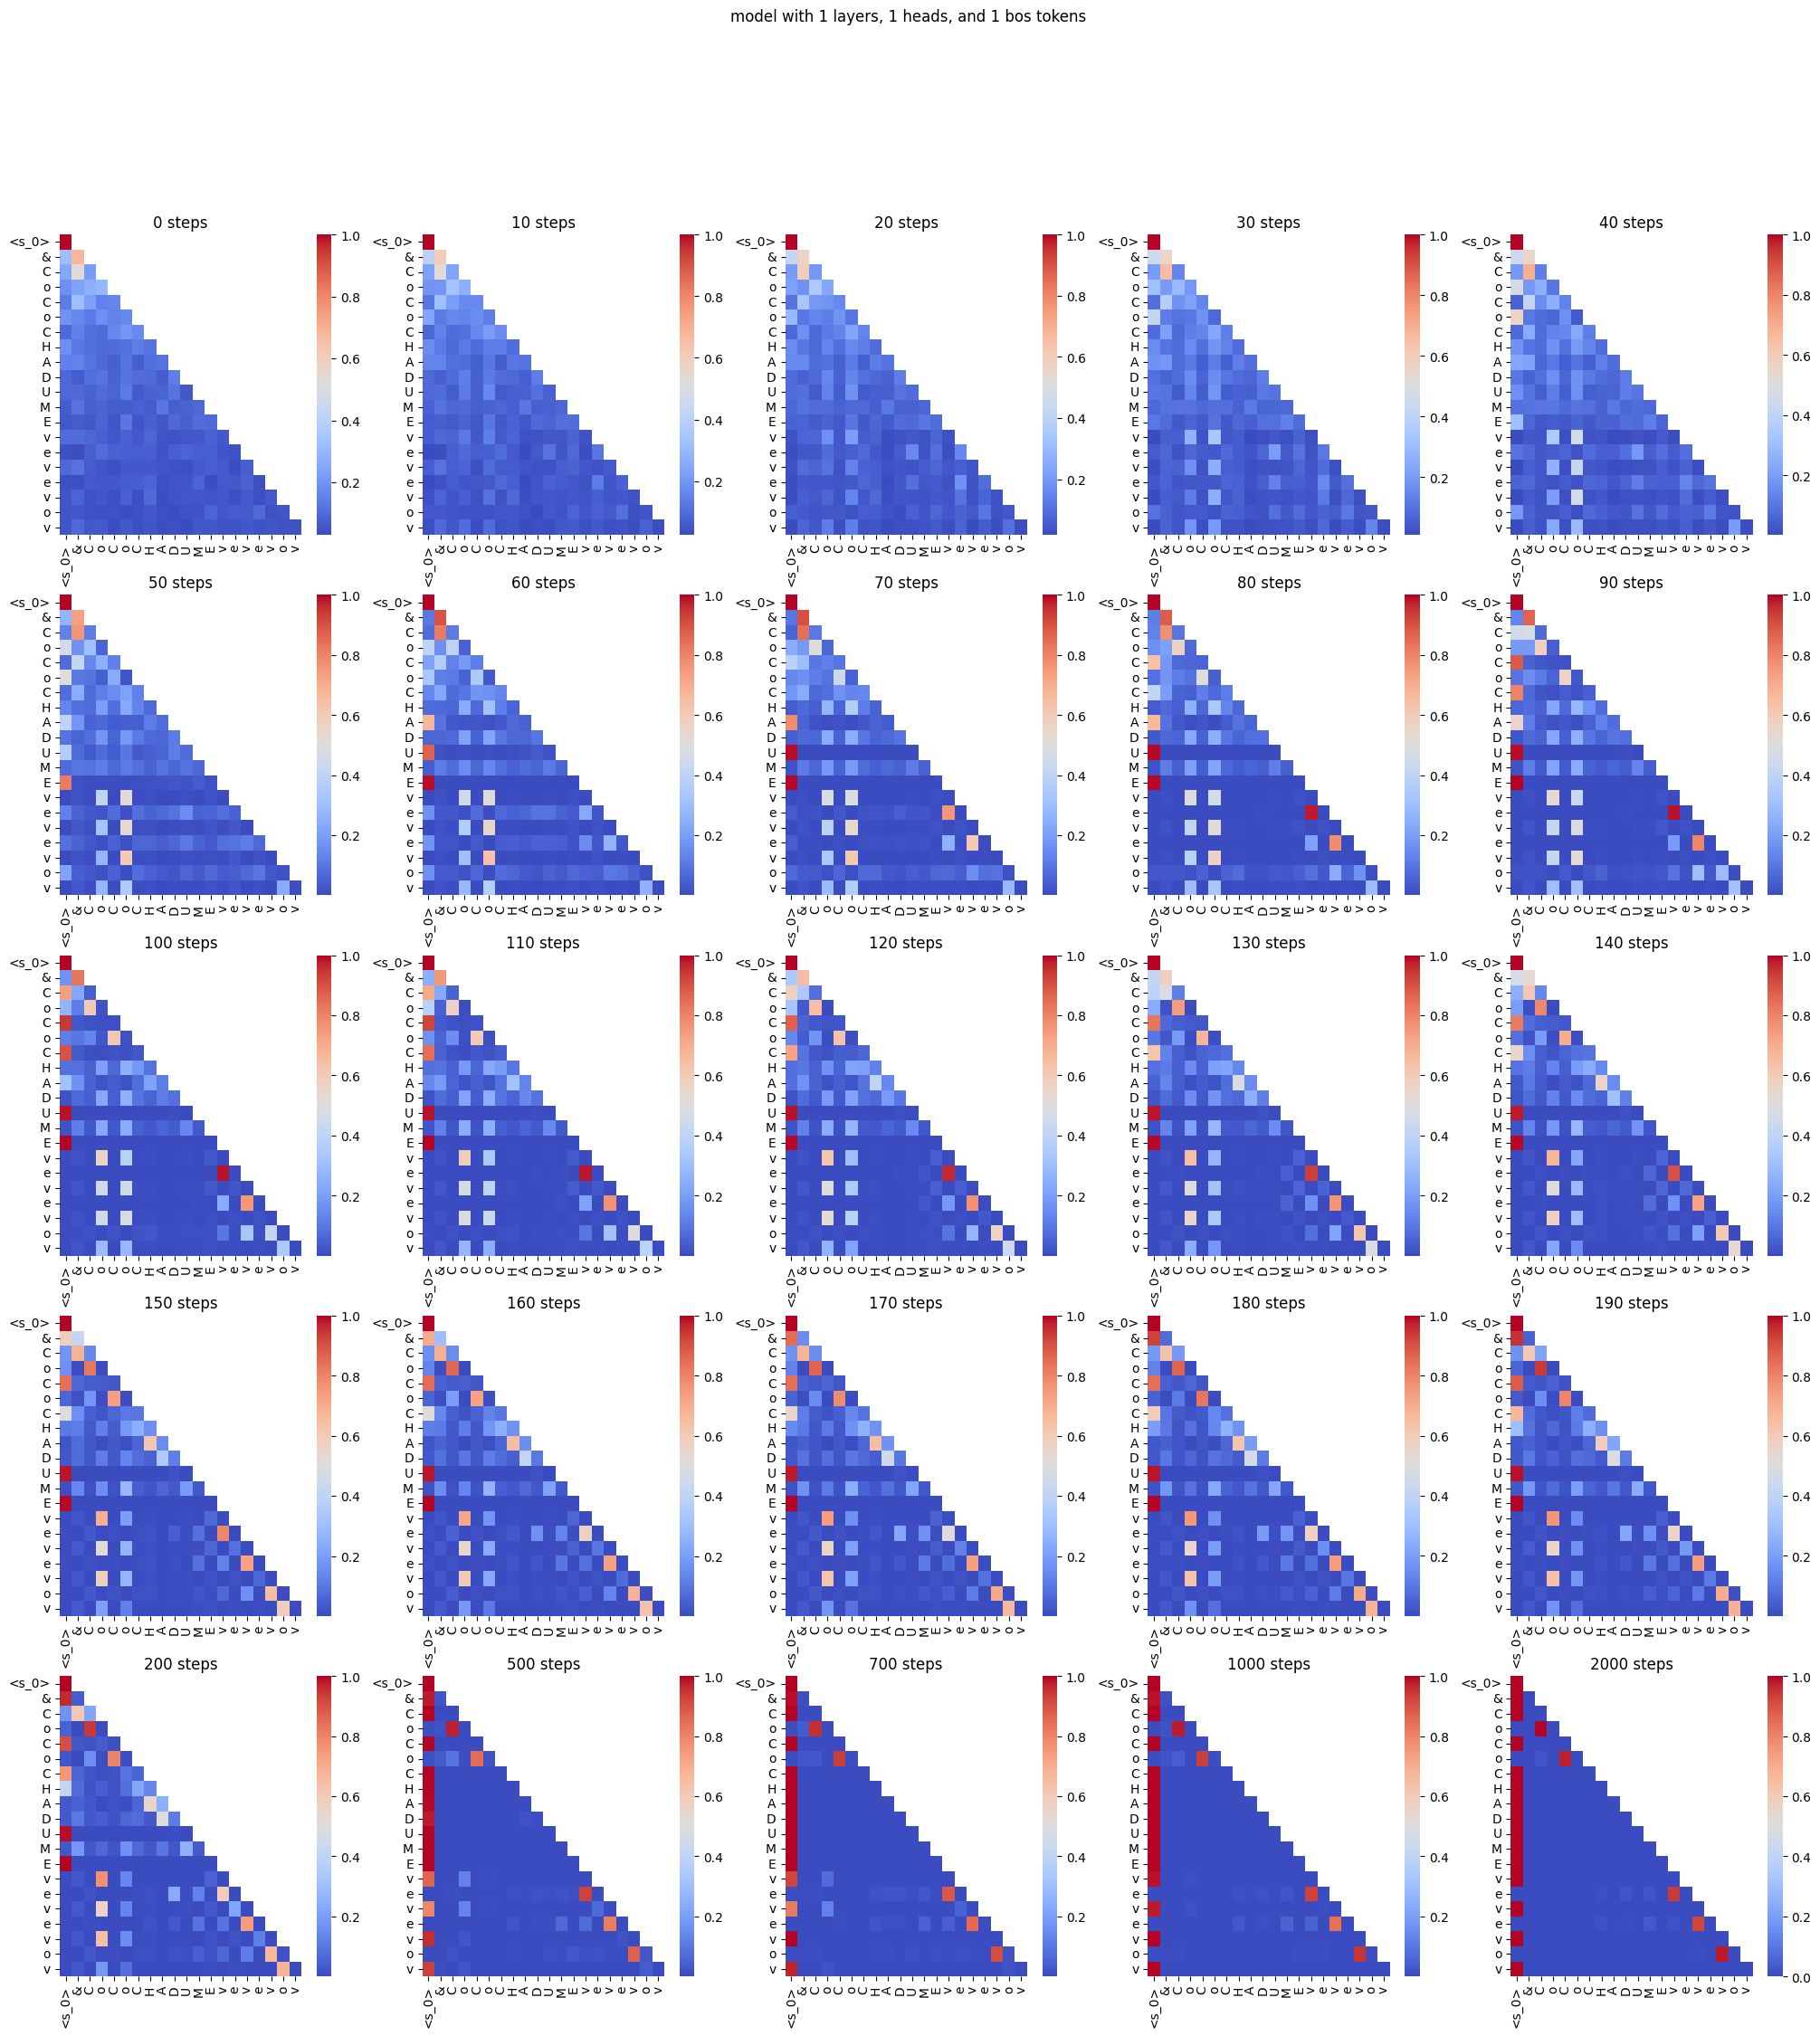

In [78]:
# scores = data['scores'][layer_idx]
seq_len = 20
seq_idx = 1
text = ds.decode(x[seq_idx, :seq_len].numpy())

fig, axes = plt.subplots(5, 5, figsize=(5*5, 5*5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    step = steps_list[i]
    # hacky
    step = str(step)
    plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list_steps[step], text)
    # ax.set_xticks(list(ds.decode(x[seq_idx, :20].numpy())))
    ax.set_title(f"{step} steps")
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

<Axes: title={'center': 'Layer0 Head0'}>

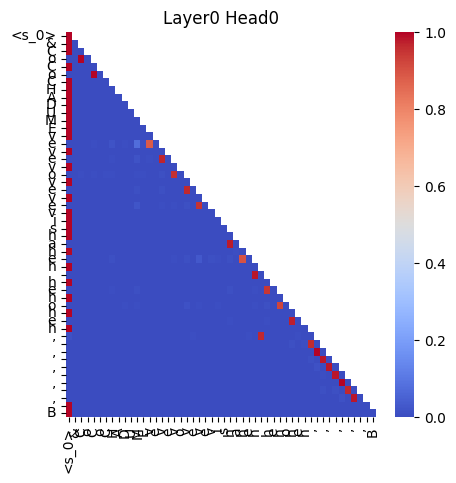

In [84]:
seq_len = 50
seq_idx = 1
text = ds.decode(x[seq_idx, :seq_len].numpy())
step = str(4999)
fig, ax = plt.subplots(figsize=(5, 5))
plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list_steps[step], text)


In [110]:
text[31], x[seq_idx, 31]

(' ', tensor(1))

<BarContainer object of 67 artists>

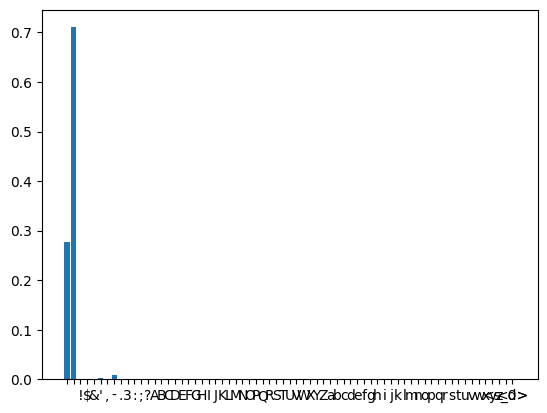

In [109]:
plt.bar(ds.decode(ds.tok_range), ds.cond[6])

# We get very nice dormant phenonmenon in dormant_copy_2 task. There are only a few exception tokens that do not dormant. A conjecture is that these tokens have special transition probs, and therefore utilize some shortcuts in attention mechanism.

# check the L3 case to see if there are massive tokens

In [114]:
model, x, y = load_model(n_layers=3)

In [115]:
predicts_L3, outputs_list_L3 = model.modified_forward_with_hook(x, hook)

In [119]:
layer_idx = 0
outputs_list_L3[layer_idx]['output'].norm(dim=-1)[0, :]

tensor([68.6363, 25.4210, 16.1146, 25.6668, 15.4496, 25.4077, 16.6889, 25.3955,
        15.6830, 25.0396, 16.6966, 25.9124, 16.7803, 25.5623, 16.3898, 25.1270,
        15.3079, 25.8985, 14.8579, 25.5520, 25.3371, 15.8893, 26.0146, 16.2597,
        26.7486, 16.1741, 26.2535, 23.6798, 15.6393, 24.2384, 25.4783, 15.9070,
        26.8524, 14.8457, 24.6067, 26.2423, 25.9099, 16.1282, 24.8642, 26.2714,
        15.9776, 25.5932, 16.9250, 24.4024, 25.3311, 15.8523, 26.1975, 24.5928,
        29.1310, 27.5373, 26.2886, 15.0008, 26.6468, 16.5904, 26.5098, 28.9845,
        26.8087, 28.4441, 28.4248, 26.1811, 26.9250, 29.1693, 23.8667, 24.9811,
        27.2621, 28.4967, 26.7279, 28.9750, 28.4229, 26.1650, 28.0394, 27.4899,
        28.0667, 26.0172, 27.6532, 24.0241, 16.0639, 24.1436, 15.6343, 24.8521,
        28.5064, 26.8748, 15.6300, 26.3936, 15.0757, 25.2692, 26.7755, 14.7504,
        27.0609, 26.2012, 14.6665, 26.8924, 27.4769, 25.7489, 16.2533, 25.3661,
        24.7604, 15.0849, 23.8958, 15.61

# Test on dormant copy with only three trigger tokens

In [143]:
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server="/data/tianyu_guo/birth/gens/pre_final/dormant_test", n_layers=1, n_heads=1, bos_num=1, train_steps=5000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)

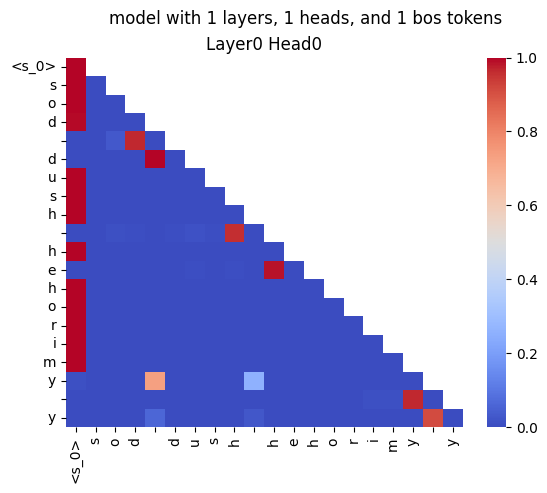

In [144]:
seq_idx, layer_idx, head_idx, seq_len = 20, 0, 0, 20
text = ds.decode(x[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
ax = plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

In [145]:
ds.idxs

[58, 43, 1]

In [146]:
x_dormant = np.array([[65, 56, 52, 50, i, 0, i] for i in ds.tok_range])
x_dormant = torch.from_numpy(x_dormant)
predicts_dormant, outputs_list_dormant = model.modified_forward_with_hook(x_dormant, hook)
cutoff = 0.9
trigger_toks = [i for i in ds.tok_range if outputs_list_dormant[0]['attn_weights'][i, 0, 4, 0]<cutoff]

In [147]:
trigger_toks

[1, 3, 43, 58, 65]